# Reseting Models & repeated model simulations
Standard simulation scenarios for computational models are:
1. Repeated simulation under changed initial conditions
2. Repeated simulation under changed parameters & fixed initial conditions
3. Simulation of period of time, than change of parameters and continuation from the given concentrations

In [ ]:
from __future__ import print_function
%matplotlib inline

# Simulating simple test model

import roadrunner

from simapp.models import CompModel
mtest = CompModel.objects.get(model_id="test_3")
print(mtest)
r = roadrunner.RoadRunner(mtest.filepath)
# r = roadrunner.RoadRunner("test_3.xml")

# settings
absTol = 1E-6
relTol = 1E-6
absTol = absTol * min(r.model.getCompartmentVolumes())  # absTol relative to the amounts
integrator = r.getIntegrator()
integrator.setValue('stiff', True)
integrator.setValue('absolute_tolerance', absTol)
integrator.setValue('relative_tolerance', relTol)

# integrate
r.simulate(0,10, 100)
print('-'*80)
print(r)
print('-'*80)

# plot
r.plot()

## Resetting values in the model
How to change parameters in the model and recalculate depending variables. This is needed for initializing SBML models in roadrunner with different parameters and volumes.

In [ ]:
from roadrunner import SelectionRecord
# load model
r = roadrunner.RoadRunner("test_3.xml")
r.reset(SelectionRecord.ALL)  # full reset (parameters and concentrations)

# make a concentration backup (needed later)
concentration_backup = dict()
for sid in r.model.getFloatingSpeciesIds():
    concentration_backup[sid] = r["[{}]".format(sid)]

# initial state
print(r.x_cell, r.Vol_c, r['[c__gal]'])

In [ ]:
# change parameter 
# -> the depending inital assignments are not updated (makes sense, are only initial)
r.x_cell = 10E-6  # [m]
print(r.x_cell, r.Vol_c, r['[c__gal]'])
# reload resets(SelectionRecord.ALL)
r = roadrunner.RoadRunner("test_3.xml")
print(r.x_cell, r.Vol_c, r['[c__gal]'])
# so do the change again
r.x_cell = 10E-6  # [m]
print(r.x_cell, r.Vol_c, r['[c__gal]'])

In [ ]:
# force an update via recalculating depending assignments
# -> Volume is updated, but also the concentrations due to changes in volume !
from roadrunner import SelectionRecord
r.reset(SelectionRecord.INITIAL_GLOBAL_PARAMETER)
print(r.x_cell, r.Vol_c, r['[c__gal]'])

In [ ]:
# a reset of the initial concentrations does not bring the concentrations back
r.reset()  # only reset initial concentrations
print(r.x_cell, r.Vol_c, r['[c__gal]'])

r.reset(SelectionRecord.INITIAL_FLOATING_CONCENTRATION)  # only reset initial concentrations
print(r.x_cell, r.Vol_c, r['[c__gal]'])

# the backup of the concentrations is needed
# restore concentrations
# -> now same initial concentrations under changed parameters
for key, value in concentration_backup.iteritems():
    r.model['[{}]'.format(key)] = value
print(r.x_cell, r.Vol_c, r['[c__gal]'])

In [ ]:
# To reset all use
r.reset(SelectionRecord.ALL)  # full reset (parameters and concentrations)
print(r.x_cell, r.Vol_c, r['[c__gal]'])

## 1. Repeated simulation under changed initial conditions
Repeat the simulation with changing initial conditions

('relative_tolerance', 'absolute_tolerance', 'stiff', 'maximum_bdf_order', 'maximum_adams_order', 'maximum_num_steps', 'maximum_time_step', 'minimum_time_step', 'initial_time_step', 'multiple_steps', 'variable_step_size')
['time', '[c__gal]']
('tend:', 3.2967312819333574)
('tend:', 6.6982056469838493)
('tend:', 14.427155438216113)
('tend:', 20.0)
('tend:', 20.0)
('tend:', 20.0)
('tend:', 15.939394344800906)
('tend:', 14.899242854659615)
('tend:', 18.978166192571607)
('tend:', 19.614127934707764)


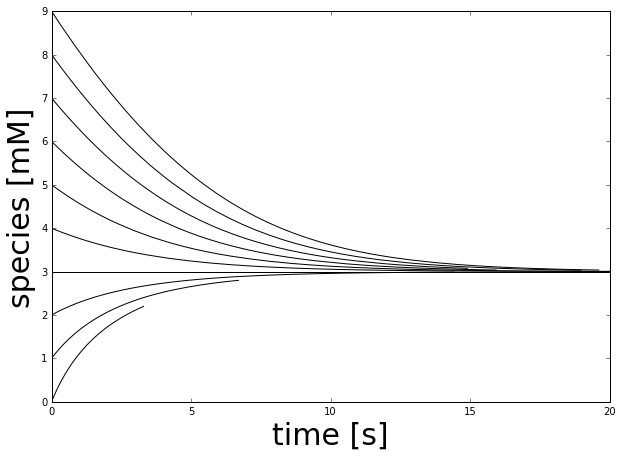

In [6]:
# load & reset model
%matplotlib inline
import roadrunner
from roadrunner import SelectionRecord
r = roadrunner.RoadRunner("test_3.xml")
r.reset(SelectionRecord.ALL)  # full reset, also happening in reload, but just to be sure

# simulation settings
absTol = 1E-6
relTol = 1E-6
absTol = absTol * min(r.model.getCompartmentVolumes())  # absTol relative to the amounts
integrator = r.getIntegrator()

print(integrator.getSettings())

integrator.setValue('stiff', True)
integrator.setValue('absolute_tolerance', absTol)
integrator.setValue('relative_tolerance', relTol)
integrator.setValue('variable_step_size', True)

# selection
print(r.selections)

# simulation
tend = 20.0  # [s]
Nsim = 10    # number of repeats
results = []
for k in xrange(Nsim):
    # change initial concentration
    r['init([c__gal])'] = k
    # simulate
    s = r.simulate(0, tend)
    # store solution
    results.append(s)
    # reset the initial concentrations
    r.reset()

# plot the results
import matplotlib.pylab as plt
plt_fontsize = 30
plt.figure(figsize=(10,7))
for s in results:
    plt.plot(s[:,0], s[:,1:], '-', color='black')
    print('tend:', s[-1,0]) 
    
plt.xlabel('time [s]', fontsize=plt_fontsize)
plt.ylabel('species [mM]', fontsize=plt_fontsize)

## 2. Repeated simulation under changed parameters & fixed initial conditions
Now the more complex case of changing parameters & fixed initial conditions. 

In [ ]:
r.reset(SelectionRecord.ALL)  # full re